# DDPM

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
set_seed(1103, False)

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

## Load the dataset

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [TF.resize(TF.to_tensor(i), (32,32), antialias=False) for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 64
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
xb.shape

torch.Size([64, 1, 32, 32])

## Create model

In [ ]:
from diffusers import UNet2DModel

In [ ]:
UNet2DModel?

Init signature:
UNet2DModel(
    sample_size: Union[int, Tuple[int, int], NoneType] = None,
    in_channels: int = 3,
    out_channels: int = 3,
    center_input_sample: bool = False,
    time_embedding_type: str = 'positional',
    freq_shift: int = 0,
    flip_sin_to_cos: bool = True,
    down_block_types: Tuple[str] = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    up_block_types: Tuple[str] = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels: Tuple[int] = (224, 448, 672, 896),
    layers_per_block: int = 2,
    mid_block_scale_factor: float = 1,
    downsample_padding: int = 1,
    downsample_type: str = 'conv',
    upsample_type: str = 'conv',
    dropout: float = 0.0,
    act_fn: str = 'silu',
    attention_head_dim: Optional[int] = 8,
    norm_num_groups: int = 32,
    attn_norm_num_groups: Optional[int] = None,
    norm_eps: float = 1e-05,
    resnet_time_scale_shift: str = 'default',
    add_attention: bool =

In [ ]:
model = UNet2DModel(block_out_channels=(32,64,128,128))

## Training - easy with a callback!

In [ ]:
n_steps = 1000
beta_min, beta_max = 10 ** (-4), 0.02

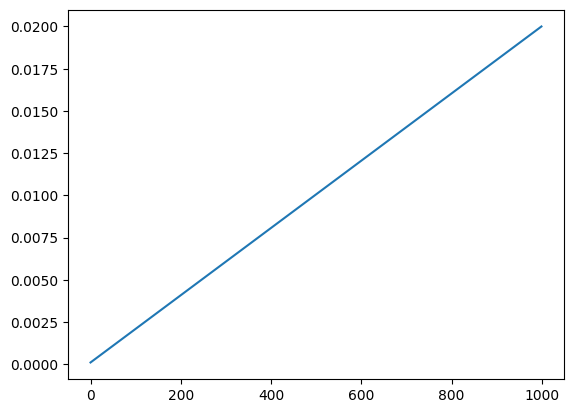

In [ ]:
betas = torch.linspace(beta_min, beta_max, n_steps)
plt.plot(betas);

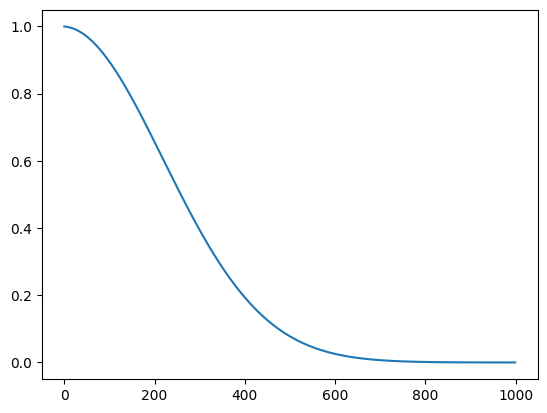

In [ ]:
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0)
plt.plot(alphas_bar);

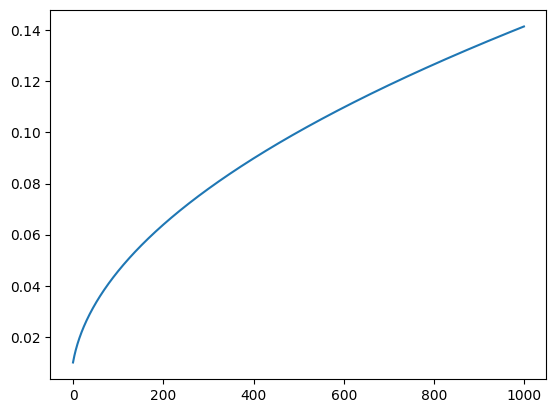

In [ ]:
sigmas = betas.sqrt()
plt.plot(sigmas);

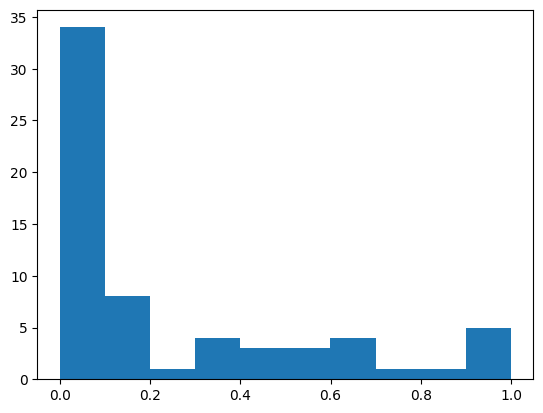

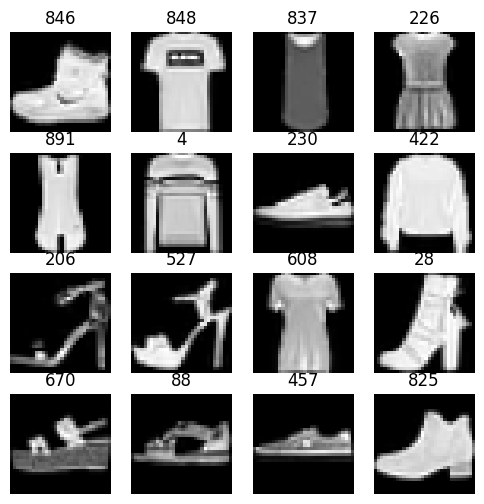

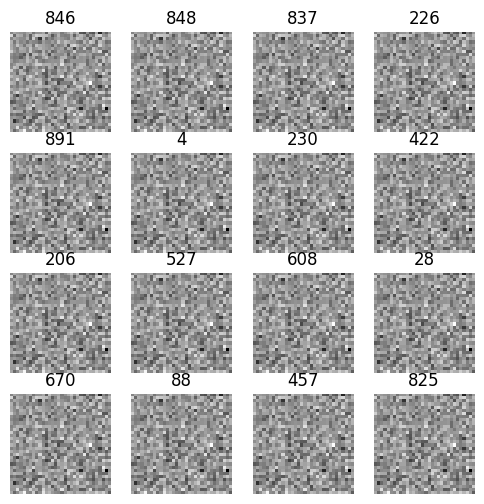

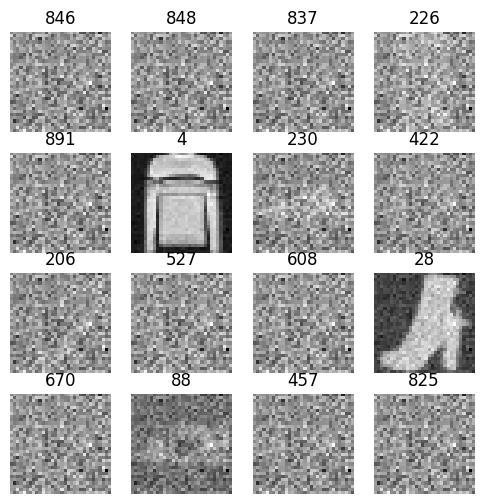

In [ ]:
set_seed(1103, False)
epsilon = torch.randn((xb[0].shape))
t = torch.randint(0, n_steps, (bs,), dtype=torch.int64)
alpha_bar_t = alphas_bar[t][:, None, None, None]
plt.hist(alpha_bar_t.reshape(-1))
original_part = alpha_bar_t.sqrt() * xb
noise_part = (1 - alpha_bar_t).sqrt() * epsilon
xt = original_part + noise_part
titles = list(map(lambda x: str(x.item()), t))[:16]
show_images(original_part[:16], imsize=1.5, titles=titles)
show_images(noise_part[:16], imsize=1.5, titles=titles)
show_images(xt[:16], imsize=1.5, titles=titles)

In [ ]:
class DDPMCB(TrainCB):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.betas = torch.linspace(beta_min, beta_max, n_steps)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        self.sigmas = self.betas.sqrt()  # The simpler of the 2

    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[0]).sample

    def before_batch(self, learn):
        device = learn.batch[0].device
        bs = learn.batch[0].shape[0]
        epsilon = torch.randn((learn.batch[0].shape), device=device)
        x0 = learn.batch[0]
        t = torch.randint(0, self.n_steps, (bs,), dtype=torch.int64)
        alpha_bar_t = self.alphas_bar[t][:, None, None, None].to(device)
        xt = alpha_bar_t.sqrt() * x0 + (1 - alpha_bar_t).sqrt() * epsilon
        learn.batch = ((xt, t.to(device)), epsilon)

    def sample(self, model, sz):
        device = next(model.parameters()).device
        with torch.no_grad():
            x = torch.randn(sz, device=device)
            bs = x.shape[0]
            process = []
    
            for t in reversed(range(self.n_steps)):
                t_batch = torch.full((bs,), t, dtype=torch.int64)
    
                # Repametrized equation (4)
                noise_pred = model(x, t_batch.to(device)).sample
                alpha_bar_t = self.alphas_bar[t]
                x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
                x0_est = x0_est.clamp(0, 1)
    
                # Equations (7) and (8)
                alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else self.alphas_bar[t - 1]
                x0_coef = alpha_bar_t_minus_1.sqrt() * self.betas[t] / (1 - alpha_bar_t)
                xt_coef = self.alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
                noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
                x = x0_coef * x0_est + x * xt_coef + self.sigmas[t] * noise_sample
    
                process.append(to_cpu(x))
    
        return process

In [ ]:
set_seed(1103, False)
lr = 0.001
epochs = 5
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
ddpm = DDPMCB(1000, 10**(-4), 0.02)
cbs = [ddpm, DeviceCB(), ProgressCB(True), MetricsCB(), sched]
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32,64,128,128))
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=optim.AdamW)

loss,epoch,train
0.074,0,train
0.025,0,valid
0.022,1,train
0.020,1,valid
0.018,2,train
0.018,2,valid
0.017,3,train
0.017,3,valid
0.015,4,train
0.016,4,valid


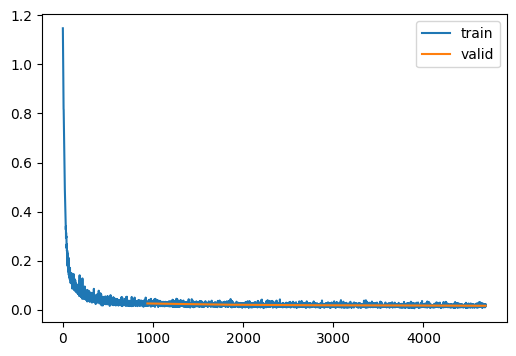

In [ ]:
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "15_ddpm.pkl")

## Inference

In [ ]:
model_path = Path("models")
learn.model = torch.load(model_path / "15_ddpm.pkl")

In [ ]:
set_seed(1103, False)
samples = ddpm.sample(learn.model, (16, 1, 32, 32))

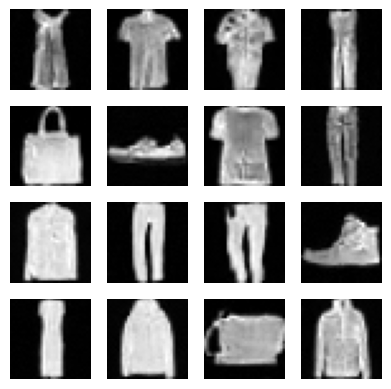

In [ ]:
show_images(samples[-1], imsize=1.2)

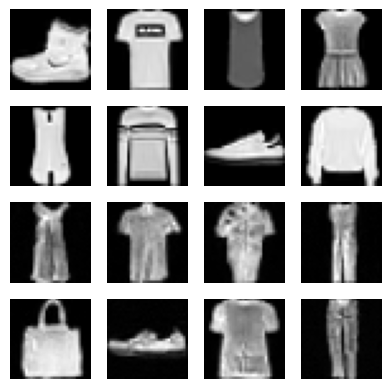

In [ ]:
show_images([*xb[:8], *samples[-1][:8]], imsize=1.2)

In [ ]:
xb[0].min(), xb[0].mean(), xb[0].max()

(tensor(0.), tensor(0.3806), tensor(0.9522))

In [ ]:
samples[-1][-1].min(), samples[-1][-1].mean(), samples[-1][-1].max()

(tensor(0.), tensor(0.3666), tensor(0.8683))

In [ ]:
xb.min(), xb.mean(), xb.max()

(tensor(0.), tensor(0.2872), tensor(0.9997))

In [ ]:
samples[-1].min(), samples[-1].mean(), samples[-1].max()

(tensor(0.), tensor(0.2831), tensor(0.9998))

In [ ]:
samples[-1][0, 0, 15:17,15:17]

tensor([[0.3361, 0.2553],
        [0.3192, 0.2314]])

In [ ]:
samples[-1][0, 0, :2,:2]

tensor([[0.0004, 0.0000],
        [0.0040, 0.0033]])

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,4))
frames = [0, 10, 200, 600] + list(range(800, 990, 10)) + list(range(990, 1000)) + [999] * 14

def _show(i):
    show_image(samples[frames[i]][-1], ax=ax)
animation = FuncAnimation(fig, _show, frames=len(frames))

display(HTML(animation.to_html5_video()))
plt.close()